In [69]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [70]:
# Read both Process and Quality extracted from plant

dfp =pd.read_excel("./data/Mill_Data.xlsx", sheet_name="Process_Data")
dfq =pd.read_excel("./data/Mill_Data.xlsx",sheet_name="Quality_Data")

In [71]:
# Convert to parquet as a reference data to be uploaded to S3 for orchestration

dfp.to_parquet("./data/Process_Data.parquet")
dfq.to_parquet("./data/Quality_Data.parquet")

In [72]:
# Convert object to datetime columns

dfp['Date']= pd.to_datetime(dfp['Date'],format='mixed')
dfq['Date']= pd.to_datetime(dfq['Date'],format='mixed')

### CHECKING THE DATA STRUCTURE

In [73]:
print(dfp.shape,dfq.shape)

(10246, 22) (3724, 18)


In [74]:
dfp.describe()

,Date,Running Hour,Clinker Feed Rate,Limestone Feed Rate,Gypsum Feed Rate,TOTAL FEED RATE,Compressor Blower,Air Separator,BC36,Bucket Elevator,...,Material Temperature,Mill Outlet Temperature,Air Separator Speed,Mill Outlet,Mill Bag Filter Outlet,Mill Bag Filter DP,Separator Fan Inlet Damper,Separator Inlet Damper,Fresh Air Damper,Mill Dust Fan Damper
count,10246,10246.000000,10206.000000,10206.000000,10206.000000,10206.000000,10206.000000,10206.000000,10206.000000,10206.000000,...,10206.000000,10206.000000,10206.000000,10206.000000,10206.000000,10206.000000,10195.000000,10195.000000,10195.000000,10195.000000
mean,2023-11-30 11:00:42.514151936,0.714180,32.578669,3.299922,1.851897,37.716976,103.994088,30.631454,3.959390,34.404034,...,95.177446,110.642241,34.913999,-4.379588,-14.763297,7.116946,66.231548,60.551375,9.833779,52.827145
min,2023-05-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,30.410000,0.000000,-13.710000,-32.910000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-08-15 17:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,54.372500,0.240000,0.000000,0.390000,...,63.935000,81.817500,2.900000,-8.420000,-23.057500,3.200000,4.360000,17.090000,2.050000,38.900000
50%,2023-11-30 10:30:00,1.000000,43.695000,3.980000,2.370000,50.815000,110.890000,15.690000,5.300000,19.270000,...,110.340000,101.900000,46.040000,-6.360000,-18.230000,7.430000,86.350000,78.570000,2.060000,61.680000
75%,2024-03-16 05:45:00,1.000000,48.380000,4.960000,2.770000,55.940000,113.660000,18.720000,5.730000,25.090000,...,116.130000,110.300000,47.340000,-0.190000,-1.680000,10.400000,96.115000,82.135000,2.080000,71.520000
max,2024-06-30 23:00:00,1.000000,61.210000,14.220000,4.260000,67.990000,9999.000000,9999.000000,7.660000,9999.000000,...,139.220000,9999.000000,54.940000,17.540000,0.000000,24.720000,98.630000,100.000000,90.130000,100.000000
std,NaN,0.441495,21.106248,2.446516,1.230837,24.422252,338.935046,339.223442,2.494781,339.115034,...,29.862903,337.408109,19.540002,5.758950,9.916527,4.681589,38.672917,33.489920,21.697413,26.946583


In [75]:
dfp.isna().sum()

Date                           0
Running Hour                   0
Clinker Feed Rate             40
Limestone Feed Rate           40
Gypsum Feed Rate              40
TOTAL FEED RATE               40
Compressor Blower             40
Air Separator                 40
BC36                          40
Bucket Elevator               40
Kinyon Pump                   40
BM3 Main Drive                40
Material Temperature          40
Mill Outlet Temperature       40
Air Separator Speed           40
Mill Outlet                   40
Mill Bag Filter Outlet        40
Mill Bag Filter DP            40
Separator Fan Inlet Damper    51
Separator Inlet Damper        51
Fresh Air Damper              51
Mill Dust Fan Damper          51
dtype: int64

### DATA PREPARATION 

In [76]:
# Only considering a run hour of equal to 1
dfp=dfp[dfp['Running Hour'] >= 0.75]

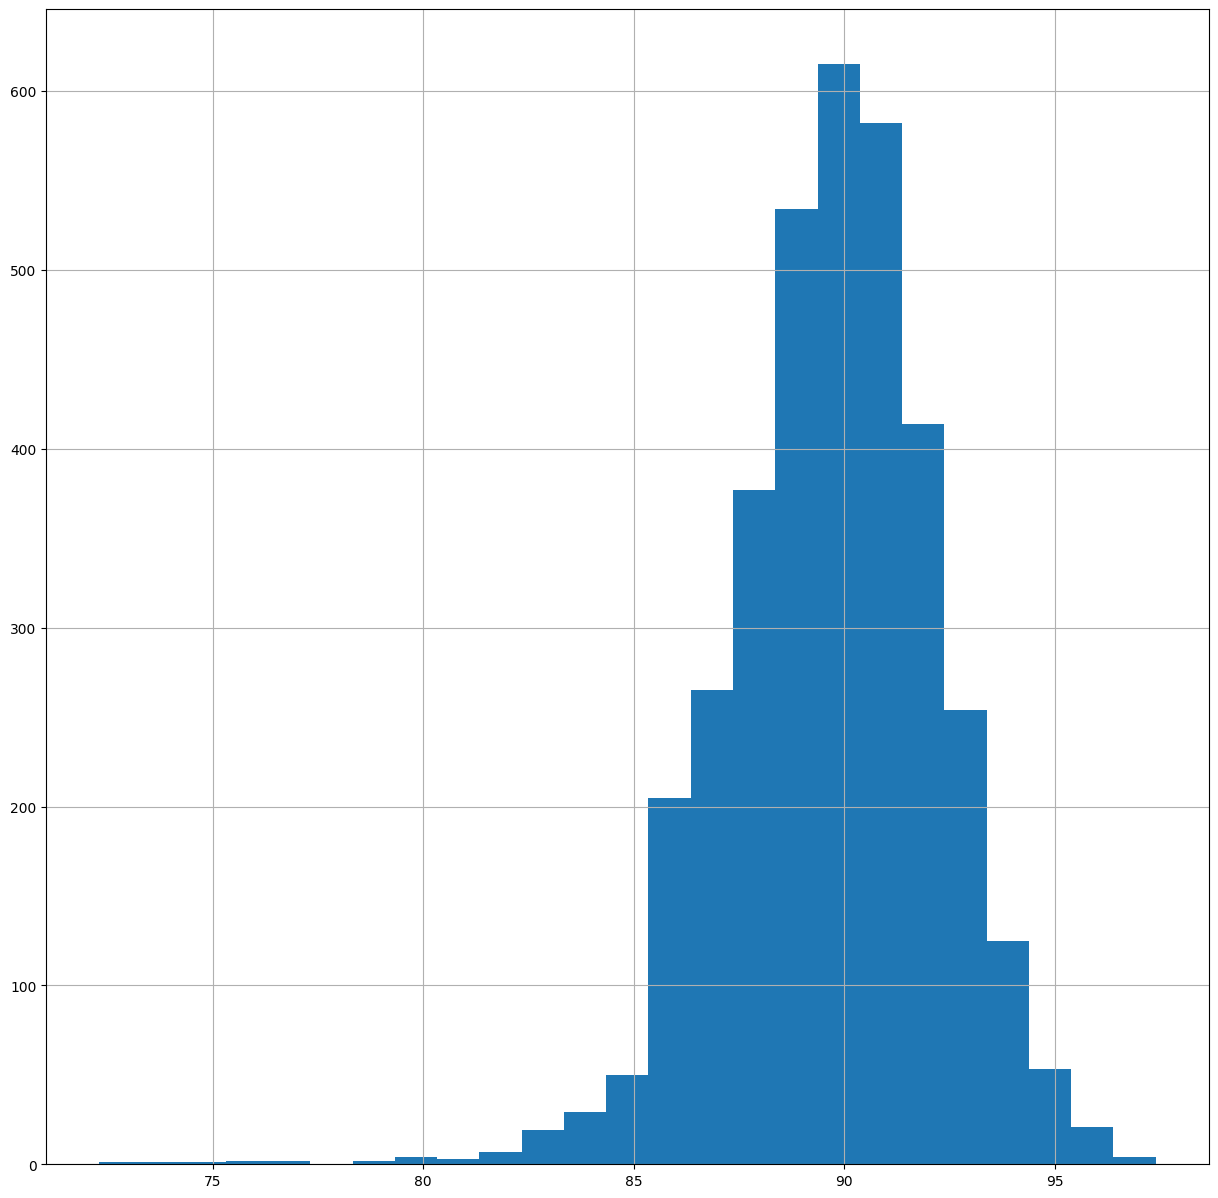

In [77]:
# Checking the target distribution 
dfq['45um'].hist(figsize=(15,15),bins=25)
plt.show()

In [78]:
# Converting rows that indicate positive mill outlet pressure to negative (sensor error)
for lab,row in dfp.iterrows():
    if dfp.loc[lab,'Mill Outlet'] >= 0:
        dfp.loc[lab,'Mill Outlet']=row['Mill Outlet'] * -1

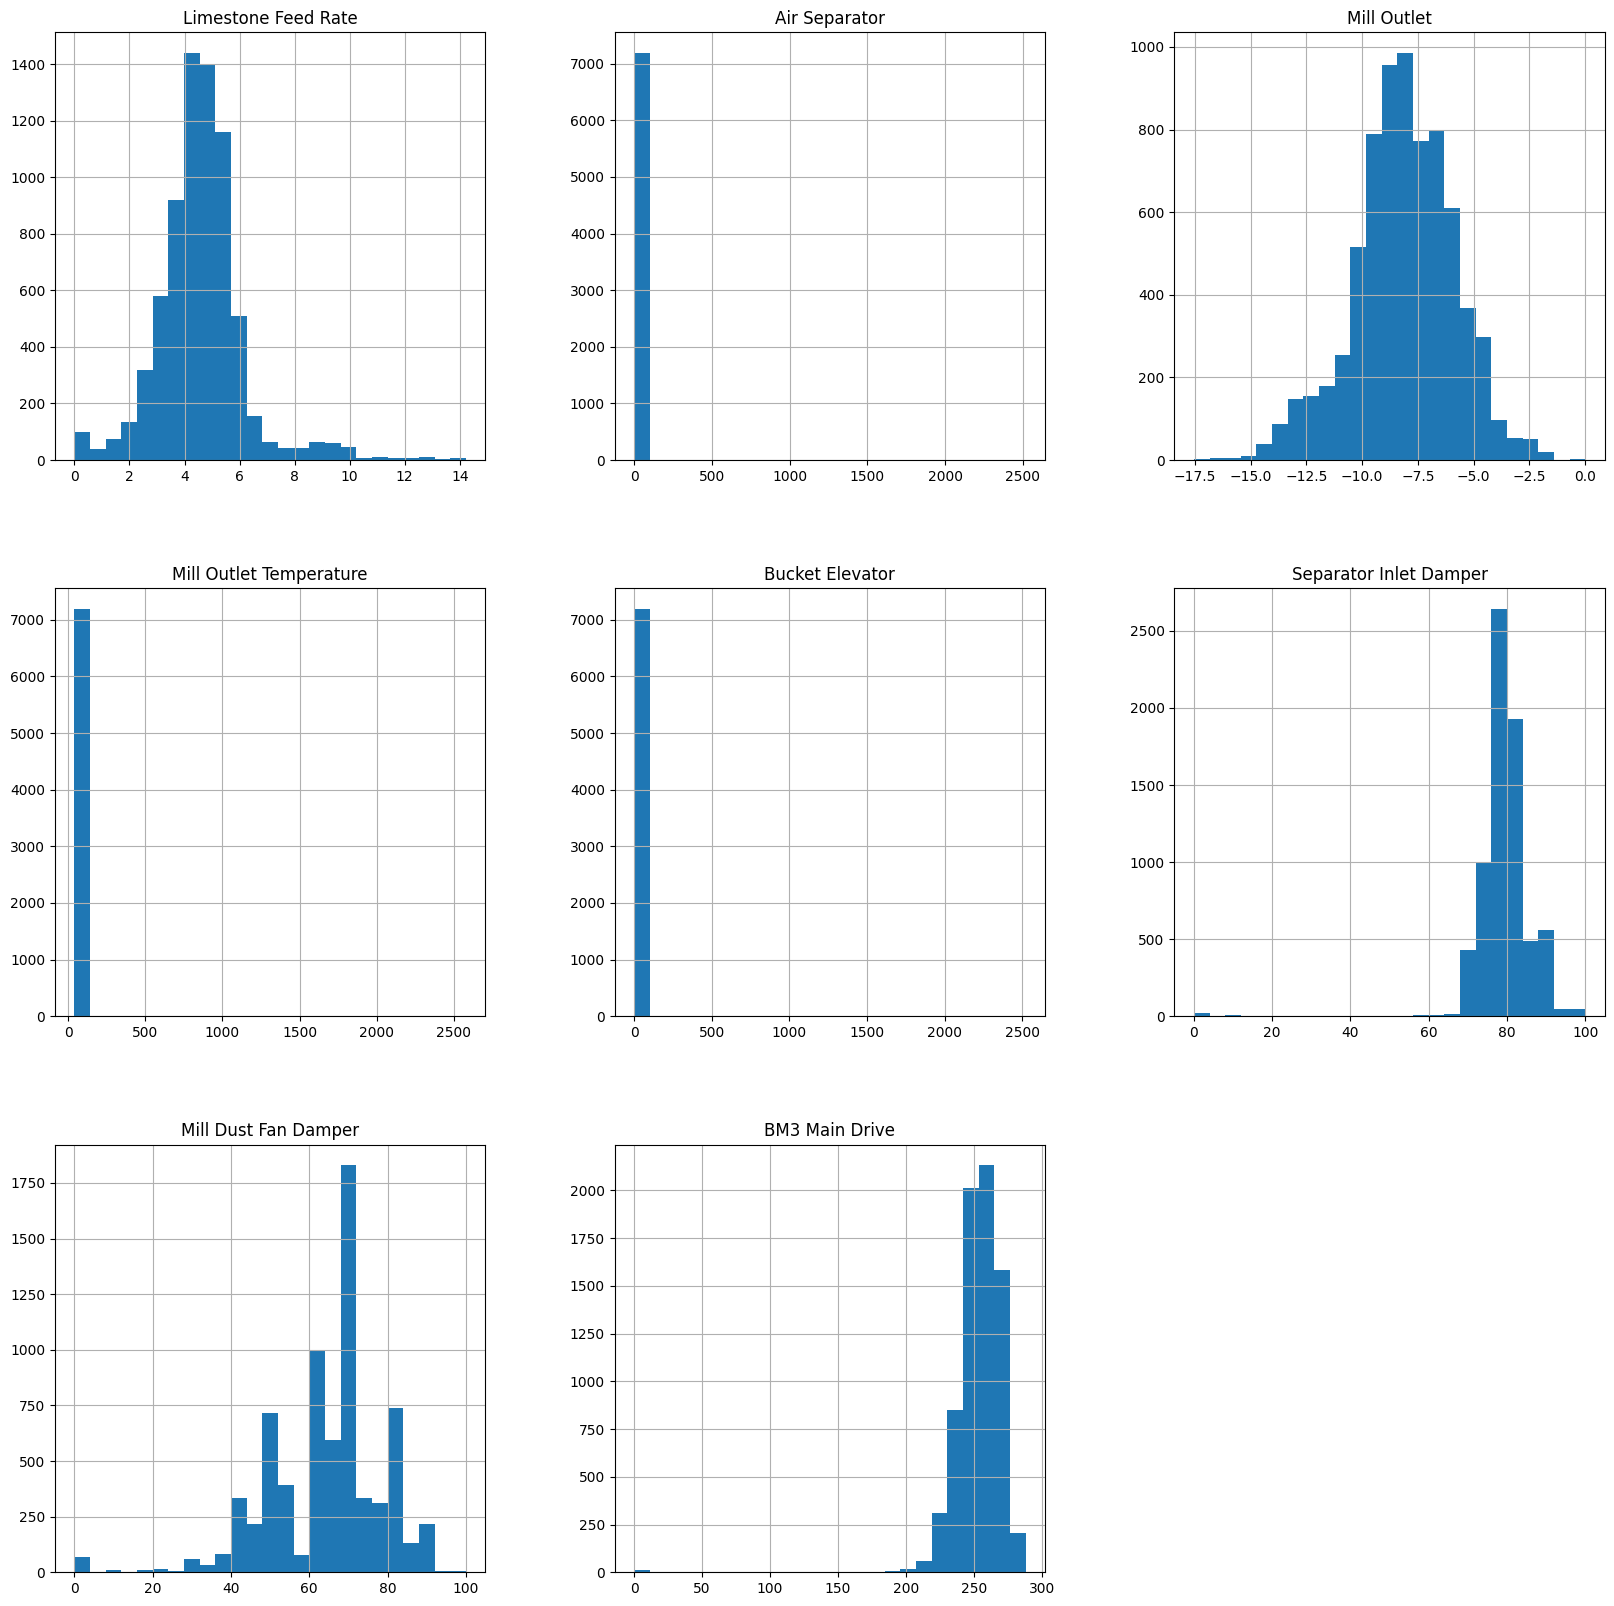

In [79]:
# Checking the distribution of the process operating parameters 
dfp[['Limestone Feed Rate','Air Separator','Mill Outlet','Mill Outlet Temperature', 'Bucket Elevator' ,'Separator Inlet Damper' \
     ,'Mill Dust Fan Damper','BM3 Main Drive']].hist(figsize=(20,20),bins=25)
plt.show()

In [80]:
# Isolating the needed data for the two datasets
dfq= dfq[['Date','45um']]
dfp=dfp[['Date','Limestone Feed Rate','Air Separator','Mill Outlet','Mill Outlet Temperature', 'Bucket Elevator' ,'Separator Inlet Damper' \
     ,'Mill Dust Fan Damper','BM3 Main Drive']]

In [81]:
# Merging the two dataframes on Date 
dff=dfq.merge(dfp, on='Date', how='inner')

In [82]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3611 entries, 0 to 3610
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     3611 non-null   datetime64[ns]
 1   45um                     3463 non-null   float64       
 2   Limestone Feed Rate      3595 non-null   float64       
 3   Air Separator            3595 non-null   float64       
 4   Mill Outlet              3595 non-null   float64       
 5   Mill Outlet Temperature  3595 non-null   float64       
 6   Bucket Elevator          3595 non-null   float64       
 7   Separator Inlet Damper   3592 non-null   float64       
 8   Mill Dust Fan Damper     3592 non-null   float64       
 9   BM3 Main Drive           3595 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 282.2 KB


In [83]:
# Data Cleaning and dropping columns with no target values 
dff.drop('Date',axis=1, inplace=True)
dff.dropna(inplace=True)
dff.shape

(3445, 9)

In [84]:
# Applying 3 sigma rule
z_scores =stats.zscore(dff)
abs_z_scores =np.abs(z_scores)
filter =(abs_z_scores <3).all(axis=1)
dfz=dff[filter]

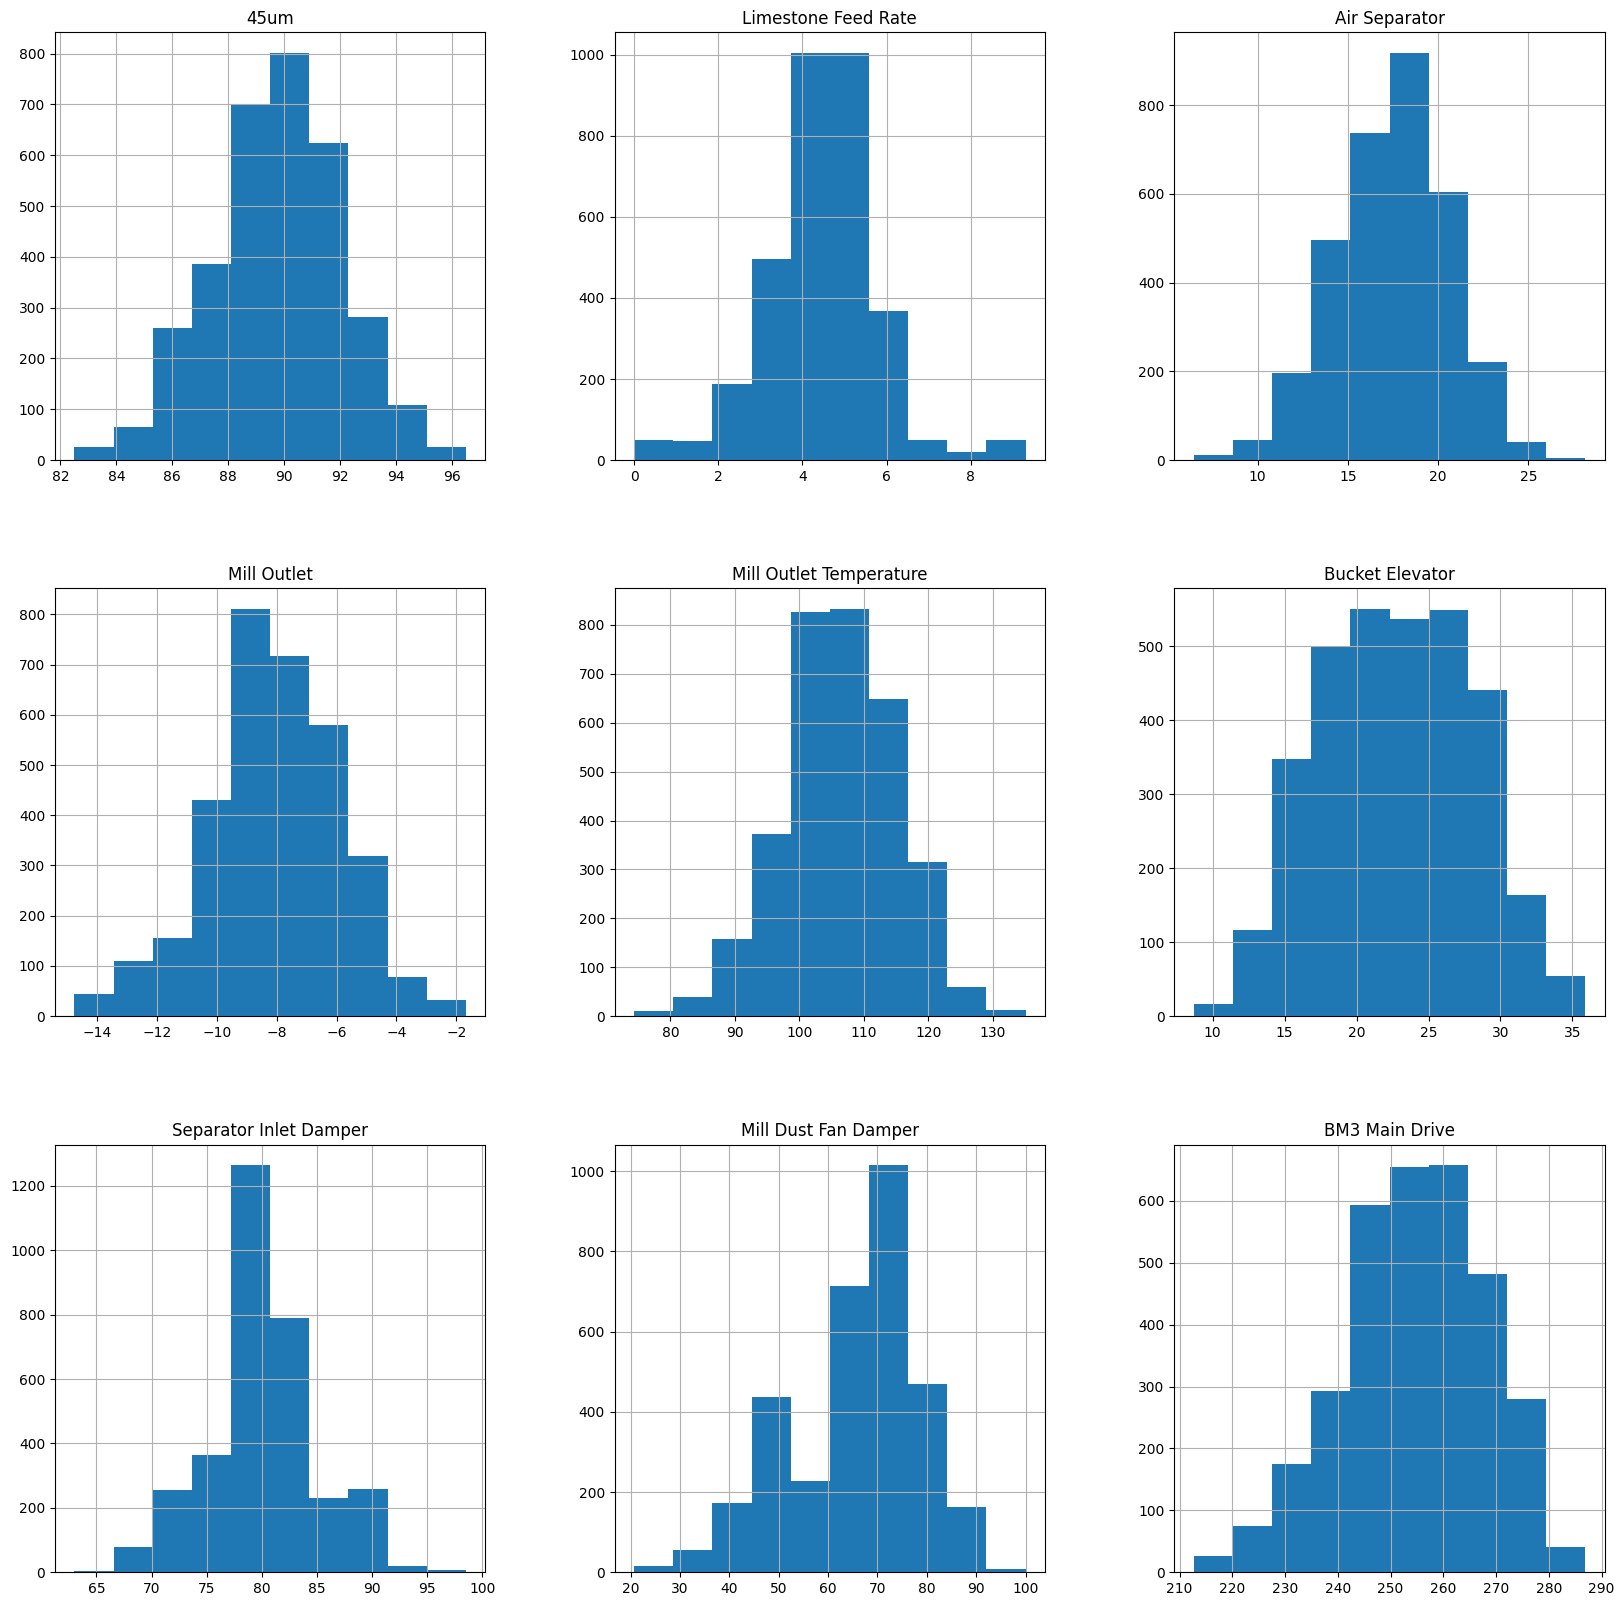

In [85]:
# Checking the final distribution of features and target
dfz.hist(figsize=(20,20))
plt.show()

(9.5, -0.5)

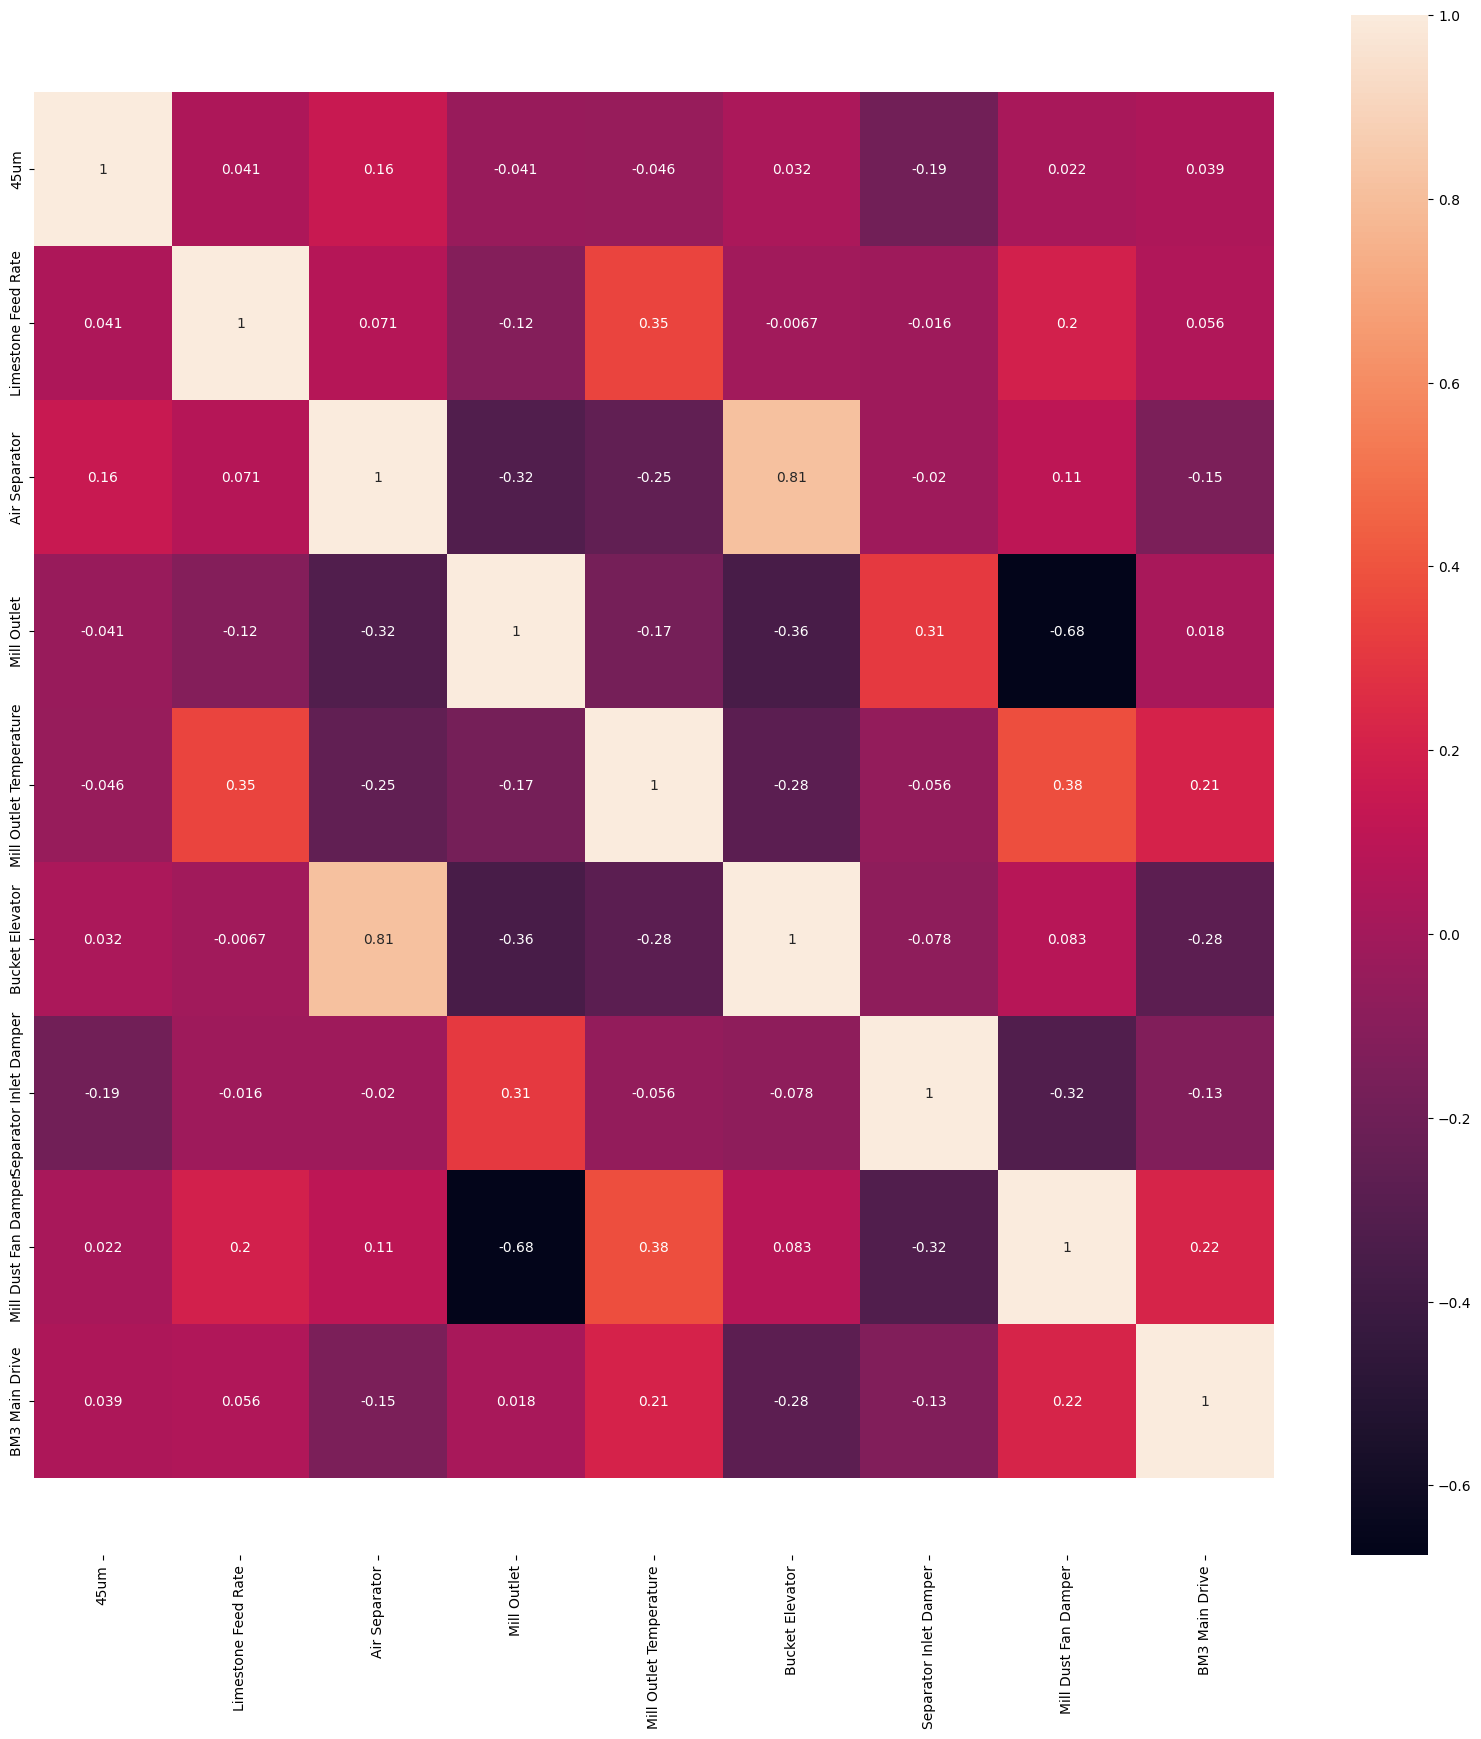

In [86]:
# Checking correlation of data
fig,ax =plt.subplots(figsize=(20,20))
ax= sns.heatmap(dfz.corr(), annot=True)
bottom, top =ax.get_ylim()
ax.set_ylim(bottom +0.5, top-0.5)

In [87]:
# Checking the final shape of data 
dfz.shape

(3276, 9)

### MODELING 

In [88]:
# finalzing the selected features to which the model will be trained
X=dfz[['Limestone Feed Rate','Air Separator','Mill Outlet','Mill Outlet Temperature', 'Bucket Elevator' ,'Separator Inlet Damper' \
     ,'BM3 Main Drive','Mill Dust Fan Damper']]
y=dfz['45um']

In [89]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [90]:
# Training the model
xg_reg=xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100,max_depth=5,eta=0.1, seed=123).fit(X_train.values,y_train.values)

In [91]:
# Testing the model 
y_pred=xg_reg.predict(X_test.values)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
rmse

2.1724055147461043

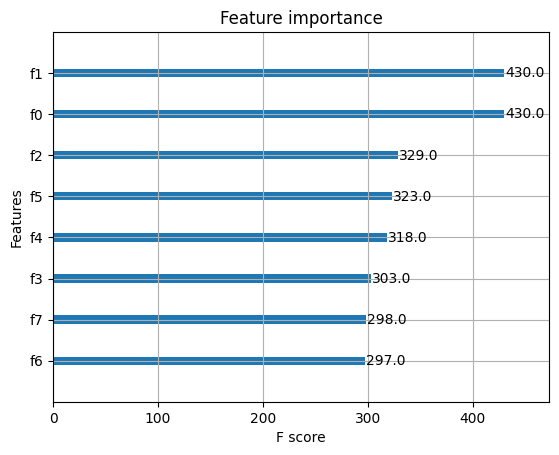

In [66]:
# Plotting feature importance
xgb.plot_importance(xg_reg)
plt.show()

In [28]:
# Saving the model
with open('./models/model.xgb', 'wb') as fout:
    pickle.dump(xg_reg,fout)

### MODELING WITH RANDOMSEARCH 

In [ ]:
rcv= xgb.XGBRegressor()
params_grid={'eta' : np.arange(0.01,0.2,0.01),
            'n_estimators' :[50,75,100,150,200],
            'subsample':np.arange(0.05,1.05, 0.05),
             'max_depth':[3,5,7,9],
            'colsample_bytree' : np.arange(0.05,1.05, 0.05)}

rand_search =RandomizedSearchCV(estimator =rcv, param_distributions=params_grid,n_iter=5000,scoring='neg_mean_squared_error',cv=5,verbose=1)
rand_search.fit(X_train.values,y_train.values)

In [ ]:
np.sqrt(np.abs(rand_search.best_score_))

In [27]:
rand_search.best_params_

{'subsample': 0.9000000000000001,
 'n_estimators': 150,
 'max_depth': 9,
 'eta': 0.060000000000000005,
 'colsample_bytree': 0.5}

### FETCHING THE MODEL FOR DEPLOYMENT MODULE (DURING LOCAL MODE RUN)

In [19]:
import mlflow
import boto3

In [3]:
from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI ="http://ec2-54-172-134-21.compute-1.amazonaws.com:5000/"
RUN_ID = 'd47c2b1532f0499d82772b931fb9c30b'
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)


In [20]:
RUN_ID = 'd47c2b1532f0499d82772b931fb9c30b'
logged_model = f's3://millproject-models/350780338872700929/{RUN_ID}/artifacts/model'
model = mlflow.pyfunc.load_model(logged_model)

2024/07/28 11:14:59 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.14.3, required: mlflow==2.12.1)
 - lz4 (current: uninstalled, required: lz4==4.3.3)
 - pandas (current: 2.2.2, required: pandas==1.5.3)
 - scikit-learn (current: 1.5.1, required: scikit-learn==1.5.0)
 - scipy (current: 1.14.0, required: scipy==1.13.1)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [5]:
model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.xgboost
  run_id: d47c2b1532f0499d82772b931fb9c30b

In [7]:
import pickle
with open('/home/nikki/MlOps_MillProject/deployment/model.xgb', 'wb') as fout:
    pickle.dump(model,fout)

In [2]:
path = mlflow.artifacts.download_artifacts(artifact_uri="s3://millproject-models/350780338872700929/d47c2b1532f0499d82772b931fb9c30b/artifacts/model/model.xgb"\
                                          ,dst_path= '/home/nikki/MlOps_MillProject/deployment/')

In [3]:
path

'/home/nikki/MlOps_MillProject/deployment/model.xgb'

### PREPARING DATA FOR MONITORING MODULE 

In [30]:
dfmon=dfq.merge(dfp, on='Date', how='inner')

In [31]:
dfmon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     3240 non-null   datetime64[ns]
 1   45um                     3106 non-null   float64       
 2   Limestone Feed Rate      3225 non-null   float64       
 3   Air Separator            3225 non-null   float64       
 4   Mill Outlet              3225 non-null   float64       
 5   Mill Outlet Temperature  3225 non-null   float64       
 6   Bucket Elevator          3225 non-null   float64       
 7   Separator Inlet Damper   3222 non-null   float64       
 8   Mill Dust Fan Damper     3222 non-null   float64       
 9   BM3 Main Drive           3225 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 253.2 KB


In [33]:
dfmon.dropna(inplace=True)
dfmon.shape

(3089, 10)

In [34]:
features =['Limestone Feed Rate','Air Separator','Mill Outlet','Mill Outlet Temperature', 'Bucket Elevator' ,'Separator Inlet Damper' \
     ,'BM3 Main Drive','Mill Dust Fan Damper','45um']

In [35]:
z_scores =stats.zscore(dfmon[features])
abs_z_scores =np.abs(z_scores)
filter =(abs_z_scores <3).all(axis=1)
dfzmon=dfmon[filter]

In [36]:
X=dfzmon[['Date','Limestone Feed Rate','Air Separator','Mill Outlet','Mill Outlet Temperature', 'Bucket Elevator' ,'Separator Inlet Damper' \
     ,'BM3 Main Drive','Mill Dust Fan Damper']]
y=dfzmon['45um']

In [37]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42, shuffle= False)

In [38]:
val_data =pd.concat([X_test,y_test],axis=1)
train_data =pd.concat([X_train,y_train],axis=1)

In [39]:
val_data.head()

,Date,Limestone Feed Rate,Air Separator,Mill Outlet,Mill Outlet Temperature,Bucket Elevator,Separator Inlet Damper,BM3 Main Drive,Mill Dust Fan Damper,45um
2253,2024-02-17 02:00:00,4.62,16.61,-5.66,101.94,20.72,79.08,231.75,50.83,89.9
2254,2024-02-17 04:00:00,4.97,15.94,-5.55,103.63,21.44,79.08,231.22,50.83,90.7
2256,2024-02-17 06:00:00,4.96,16.23,-5.75,99.44,22.12,79.08,231.58,50.82,91.5
2257,2024-02-17 08:00:00,1.88,12.40,-3.55,92.17,14.24,79.10,230.60,45.47,91.1
2258,2024-02-17 10:00:00,4.95,13.61,-4.02,101.77,17.04,79.10,235.94,45.47,89.5


In [41]:
val_data.to_parquet('./data/reference.parquet')

In [40]:
train_data.head()

,Date,Limestone Feed Rate,Air Separator,Mill Outlet,Mill Outlet Temperature,Bucket Elevator,Separator Inlet Damper,BM3 Main Drive,Mill Dust Fan Damper,45um
0,2023-05-01 00:00:00,5.39,11.10,-11.49,119.07,16.09,71.80,271.09,66.56,89.2
1,2023-05-01 02:00:00,5.58,14.67,-12.64,116.16,22.14,71.56,267.54,67.80,89.9
2,2023-05-01 04:00:00,5.54,14.78,-12.50,113.93,21.41,71.45,267.06,67.50,91.6
3,2023-05-01 06:00:00,5.19,14.03,-13.54,114.90,26.32,71.45,254.72,55.75,89.9
4,2023-05-01 08:00:00,0.92,8.44,-13.35,96.99,12.73,71.47,260.74,71.75,87.2


In [42]:
train_data.to_parquet('./data/train.parquet')